In [18]:
import osmnx as ox
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta
from shapely.geometry import MultiPoint
from scipy.spatial import KDTree
import numpy as np

In [3]:
def extract_weather_data(nodes_dict, start_date, end_date, timezone="America/New_York"):
    """
    Extracts essential weather data optimized for predicting road icing and black ice 
    from Open-Meteo for given locations.
    """
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # API parameters - Strictly parameters relevant to road icing/thawing
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "daily": [
            "temperature_2m_max",        # index 0: Highs for daytime melting
            "temperature_2m_min",        # index 1: Lows for nighttime freezing
            "precipitation_sum",         # index 2: Total moisture
            "snowfall_sum",              # index 3: Snow accumulation
            "rain_sum",                  # index 4: Rain (critical for freezing rain / flash freeze)
            "wind_speed_10m_max",        # index 5: Wind chill effect on pavement / snow drifting
            "shortwave_radiation_sum"    # index 6: Solar energy (melts ice on pavement even if air < 0°C)
        ],
        "timezone": timezone,
        "start_date": start_date,
        "end_date": end_date
    }

    all_data = []

    for k, [lat, lon, edge_list, street_count] in nodes_dict.items():
        params["latitude"] = lat
        params["longitude"] = lon

        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]
        daily = response.Daily()

        # Extract daily variables using the new optimized indices
        temperature_max = daily.Variables(0).ValuesAsNumpy()
        temperature_min = daily.Variables(1).ValuesAsNumpy()
        precipitation_sum = daily.Variables(2).ValuesAsNumpy()
        snowfall_sum = daily.Variables(3).ValuesAsNumpy()
        rain_sum = daily.Variables(4).ValuesAsNumpy()
        wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()
        shortwave_radiation_sum = daily.Variables(6).ValuesAsNumpy()

        num_days = len(temperature_max)
        edge_list_repeated = [edge_list] * num_days
        street_count_repeated = [street_count] * num_days

        daily_data = {
            "node_id": k,
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(days=1),
                inclusive="left"
            ),
            "street_count": street_count_repeated,
            "edge_list": edge_list_repeated,
            "latitude": lat,
            "longitude": lon,
            "temperature_max": temperature_max,
            "temperature_min": temperature_min,
            "precipitation_sum": precipitation_sum,
            "snowfall_sum": snowfall_sum,
            "rain_sum": rain_sum,
            "wind_speed_10m_max": wind_speed_10m_max,
            "shortwave_radiation_sum": shortwave_radiation_sum
        }
        df = pd.DataFrame(data=daily_data)
        all_data.append(df)

    # Combine all dataframes
    result_df = pd.concat(all_data, ignore_index=True)
    return result_df


In [4]:
def get_nodes_dict(G):
    nodes_dict = {}
    check_list = []
    for id, n_data in G.nodes(data=True):
        nodes_dict[id] = [n_data['y'], n_data['x'], [], n_data['street_count']]
        for n1, n2, _ in G.edges(data=True):
            if id == n1:
                nodes_dict[id][2].append((n2))
            if id == n2:
                nodes_dict[id][2].append((n1))
            if id == 0:
                if id == n1:
                    check_list.append(n2)
                if id == n2:
                    check_list.append(n1)
        nodes_dict[id][2] = list(set(nodes_dict[id][2]))

    return nodes_dict

In [107]:
def download_and_save_graph(area_of_interest, north, east, south, west, filename, tolerance=130):
    roads_filter = '["highway"~"motorway|trunk|primary|secondary"]'
    G = ox.graph_from_bbox(bbox=tuple([west, south, east, north]), retain_all=False, custom_filter=roads_filter, network_type='drive')
    G_proj = ox.project_graph(G.copy())
    G = ox.consolidate_intersections(G_proj, tolerance=tolerance, rebuild_graph=True, dead_ends=True)
    G_di = ox.convert.to_digraph(G, weight='length')
    G = nx.MultiDiGraph(G_di)
    if "simplified" in G.graph:
        del G.graph["simplified"]
        
    # B. Prevent the "TypeError: unhashable type: 'list'" crash during edge stitching
    for u, v, key, data in G.edges(keys=True, data=True):
        for attr_key, attr_value in data.items():
            if isinstance(attr_value, list):
                data[attr_key] = str(attr_value)
                
    # C. Aggressively remove degree-2 nodes, ignoring speed limit/name changes
    G = ox.simplify_graph(G, edge_attrs_differ=[])
    G = ox.project_graph(G, to_crs="EPSG:4326")
    return G

def calculate_graph_area(G):
	G_proj = ox.project_graph(G)
	gdf_nodes = ox.graph_to_gdfs(G_proj, edges=False)
	all_points = MultiPoint(gdf_nodes.geometry.tolist())
	convex_hull = all_points.convex_hull
	area_sq_meters = convex_hull.area
	area_sq_km = area_sq_meters / 1_000_000
	return area_sq_km


In [77]:
def filter_nearby_nodes_manually(G, tolerance_meters=90):
    """
    Merges close intersections using a KD-Tree, and removes nodes elsewhere 
    (degree-2 shape points) while explicitly preserving the edges between them.
    """
    print(f"Original nodes: {G.number_of_nodes()}")
    
    # 1. Project to a meter-based CRS for accurate distance calculations
    G_proj = ox.project_graph(G)
    
    # 2. Identify structural nodes (intersections and dead-ends)
    G_simple = nx.Graph(G_proj)
    structural_nodes = [n for n, d in G_simple.degree() if d != 2]
    
    # 3. Extract X, Y coordinates ONLY for structural nodes
    coords = np.array([[G_proj.nodes[n]['x'], G_proj.nodes[n]['y']] for n in structural_nodes])
    
    # 4. Build a KD-Tree and find close pairs of intersections
    tree = KDTree(coords)
    close_pairs = tree.query_pairs(r=tolerance_meters)
    
    # 5. Group interconnected close intersections using a temporary graph
    temp_g = nx.Graph()
    temp_g.add_nodes_from(structural_nodes)
    for i, j in close_pairs:
        temp_g.add_edge(structural_nodes[i], structural_nodes[j])
        
    # 6. Create a mapping to merge close intersections
    node_mapping = {}
    for group in nx.connected_components(temp_g):
        group_list = list(group)
        keeper_id = group_list[0] 
        for node in group_list:
            node_mapping[node] = keeper_id
            
    # 7. Relabel nodes in the graph to merge intersections and remove self-loops
    G_merged = nx.relabel_nodes(G_proj, node_mapping, copy=True)
    G_merged.remove_edges_from(list(nx.selfloop_edges(G_merged)))
    
    # 8. Clear the graph-level simplification flag
    if "simplified" in G_merged.graph:
        del G_merged.graph["simplified"]
        
    # --- NEW FIX: Convert list attributes to strings so they are hashable ---
    # ox.simplify_graph uses set() to aggregate attributes. Lists will crash it.
    for u, v, key, data in G_merged.edges(keys=True, data=True):
        for attr_key, attr_value in data.items():
            if isinstance(attr_value, list):
                # Turn list into a string (e.g. "['Main St', 'Route 1']")
                data[attr_key] = str(attr_value)
    # ------------------------------------------------------------------------
            
    # 9. Simplify graph (removes degree-2 nodes and stitches edges)
    G_simplified = ox.simplify_graph(G_merged, edge_attrs_differ=[])
    
    # 10. Project back to standard lat/lon (EPSG:4326)
    G_final = ox.project_graph(G_simplified, to_crs="EPSG:4326")
    
    print(f"Nodes after merging and filtering: {G_final.number_of_nodes()}")
    
    return G_final

In [6]:
# --- Dataset 1 ---
# aoI = "College Park, Maryland, US"
# north, east, south, west = 39.00164, -76.90541, 38.91214, -77.02000
# graph_name = "college_park.pickle"

# G = download_and_save_graph(aoI, north, east, south, west, graph_name, tolerance=120)

# print(f"Number of edges: {G.number_of_edges()}")
# print(f"Number of nodes: {G.number_of_nodes()}")
# print(f'Graph area is {calculate_graph_area(G)} km^2')

# # fig, ax = ox.plot_graph(G, node_size=30, node_color="r", edge_linewidth=0.5)
# # plt.show()

# start_date = "2026-01-21"
# end_date = "2026-01-29"
# nodes_dict = get_nodes_dict(G)
# weather_data = extract_weather_data(nodes_dict, start_date, end_date)
# weather_data.to_csv("graph_data/" + aoI + "_Jan_2026.csv", index=False)


In [7]:
# --- Dataset 2 ---
# aoI = "Arlington, Texaas, US"
# north, east, south, west = 32.77486, -97.04704, 32.67753, -97.17201
# graph_name = "college_park.pickle"

# G = download_and_save_graph(aoI, north, east, south, west, graph_name, tolerance=180)

# print(f"Number of edges: {G.number_of_edges()}")
# print(f"Number of nodes: {G.number_of_nodes()}")
# print(f'Graph area is {calculate_graph_area(G)} km^2')

# # fig, ax = ox.plot_graph(G, node_size=30, node_color="r", edge_linewidth=0.5)
# # plt.show()

# start_date = "2026-01-21"
# end_date = "2026-01-29"
# nodes_dict = get_nodes_dict(G)
# weather_data = extract_weather_data(nodes_dict, start_date, end_date)
# weather_data.to_csv("graph_data/" + aoI + "_Jan_2026.csv", index=False)


In [95]:
# --- Dataset 3 ---
# aoI = "Lubbock, Texaas, US"
# north, east, south, west = 33.6261, -101.7918, 33.5237, -101.9435
# graph_name = "college_park.pickle"

# G_ = download_and_save_graph(aoI, north, east, south, west, graph_name, tolerance=160)

# print(f"Number of edges: {G_.number_of_edges()}")
# print(f"Number of nodes: {G_.number_of_nodes()}")
# print(f'Graph area is {calculate_graph_area(G_)} km^2')

# fig, ax = ox.plot_graph(G_, node_size=30, node_color="r", edge_linewidth=0.5)
# plt.show()

# start_date = "2026-01-21"
# end_date = "2026-01-29"
# nodes_dict = get_nodes_dict(G_)
# weather_data = extract_weather_data(nodes_dict, start_date, end_date)
# weather_data.to_csv("graph_data/" + aoI + "_Jan_2026.csv", index=False)

Number of edges: 317
Number of nodes: 102
Graph area is 126.20703498823144 km^2


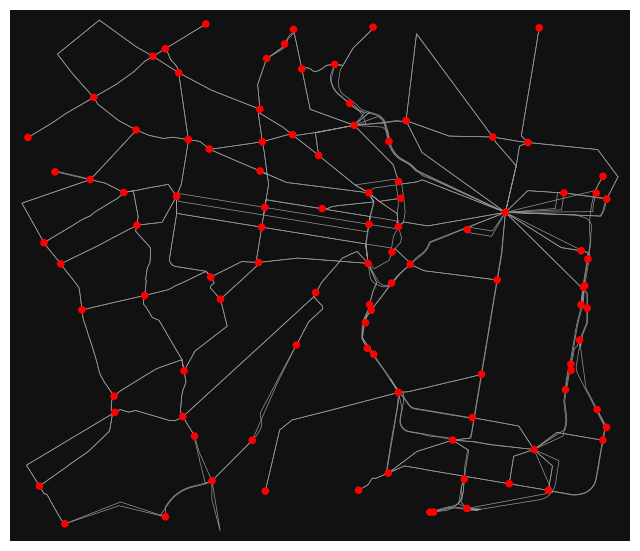

In [ ]:
# --- Dataset 4 ---
# aoI = "Philadelphia, US"
# north, east, south, west = 39.99619, -75.12794, 39.89460, -75.29016
# graph_name = "college_park.pickle"

# G_ = download_and_save_graph(aoI, north, east, south, west, graph_name, tolerance=130)

# print(f"Number of edges: {G_.number_of_edges()}")
# print(f"Number of nodes: {G_.number_of_nodes()}")
# print(f'Graph area is {calculate_graph_area(G_)} km^2')

# fig, ax = ox.plot_graph(G_, node_size=30, node_color="r", edge_linewidth=0.5)
# plt.show()

# start_date = "2026-01-21"
# end_date = "2026-01-29"
# nodes_dict = get_nodes_dict(G_)
# weather_data = extract_weather_data(nodes_dict, start_date, end_date)
# weather_data.to_csv("graph_data/" + aoI + "_Jan_2026.csv", index=False)

In [ ]:
import osmnx as ox
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime, timedelta

def load_and_visualize_graph(filename):
    """
    Loads a saved graph from a file and visualizes it as an undirected graph.
    
    Parameters:
    filename (str): The name of the file to load the graph from.
    """
    # Load the graph
    with open(filename, 'rb') as f:
        G = pickle.load(f)
    
    # Extract latitudes and longitudes
    # nodes_dict = {id: (n_data['y'], n_data['x']) for id, n_data in G.nodes(data=True)}
    nodes_dict = {}
    check_list = []
    for id, n_data in G.nodes(data=True):
        nodes_dict[id] = [n_data['y'], n_data['x'], []]
        for n1, n2, _ in G.edges(data=True):
            if id == n1:
                nodes_dict[id][2].append((n2))
            if id == n2:
                nodes_dict[id][2].append((n1))
            if id == 0:
                if id == n1:
                    check_list.append(n2)
                if id == n2:
                    check_list.append(n1)
        nodes_dict[id][2] = list(set(nodes_dict[id][2]))

    G = ox.project_graph(G)

    # Plot the graph
    fig, ax = ox.plot_graph(G, node_size=30, node_color="r", edge_linewidth=0.5)
    plt.show()

    return nodes_dict


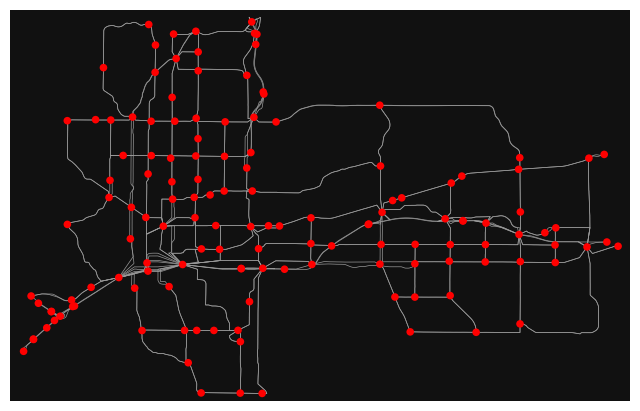

In [ ]:
nodes_dict = load_and_visualize_graph(filename="graph_files/washington.pickle")

In [ ]:
def extract_weather_data(nodes_dict, start_date, end_date, timezone="America/New_York"):
    """
    Extracts temperature, precipitation, snowfall, relative humidity, and dewpoint data from Open-Meteo for given locations.
    
    Parameters:
    nodes_dict (dict): Dictionary of node IDs with their corresponding latitudes and longitudes.
    start_date (str): The start date for the weather data in YYYY-MM-DD format.
    end_date (str): The end date for the weather data in YYYY-MM-DD format.
    timezone (str): The timezone for the weather data.
    
    Returns:
    pd.DataFrame: DataFrame containing the weather data for all locations.
    """
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # API parameters
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "daily": [
            "temperature_2m_max",       # index 0
            "temperature_2m_min",       # index 1
            "temperature_2m_mean",      # index 2
            "precipitation_sum",        # index 5
            "snowfall_sum",             # index 6
            "relative_humidity_2m_max",                 # index 7
            "relative_humidity_2m_min",      # index 8
            "dewpoint_2m_max",  # index 9
            "dewpoint_2m_min"
        ],
        "timezone": timezone,
        "start_date": start_date,
        "end_date": end_date
    }

    all_data = []

    for k, [lat, lon, edge_list] in nodes_dict.items():
        params["latitude"] = lat
        params["longitude"] = lon

        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]

        daily = response.Daily()
        # Extract daily variables using updated indices
        temperature_max = daily.Variables(0).ValuesAsNumpy()
        temperature_min = daily.Variables(1).ValuesAsNumpy()
        temperature_mean = daily.Variables(2).ValuesAsNumpy()
        precipitation_sum = daily.Variables(3).ValuesAsNumpy()
        snowfall_sum = daily.Variables(4).ValuesAsNumpy()
        relative_humidity_max = daily.Variables(5).ValuesAsNumpy()
        relative_humidity_min = daily.Variables(6).ValuesAsNumpy()
        dewpoint_max = daily.Variables(7).ValuesAsNumpy()
        dewpoint_min = daily.Variables(8).ValuesAsNumpy()

        num_days = len(temperature_max)
        edge_list_repeated = [edge_list] * num_days
      

        daily_data = {
            "node_id": k,
            "date": pd.date_range(
                start=pd.to_datetime(daily.Time(), unit="s", utc=True),
                end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(days=1),
                inclusive="left"
            ),
            "edge_list": edge_list_repeated,
            "latitude": lat,
            "longitude": lon,
            "temperature_max": temperature_max,
            "temperature_min": temperature_min,
            "temperature_mean": temperature_mean,
            "precipitation_sum": precipitation_sum,
            "snowfall_sum": snowfall_sum,
            "relative_humidity_max": relative_humidity_max,
            "relative_humidity_min": relative_humidity_min,
            "dewpoint_max": dewpoint_max,
            "dewpoint_min": dewpoint_min,
        }
        df = pd.DataFrame(data=daily_data)
        all_data.append(df)

    # Combine all dataframes
    result_df = pd.concat(all_data, ignore_index=True)
    return result_df

In [ ]:
start_date = "2025-01-01"
end_date = "2025-01-08"
weather_data = extract_weather_data(nodes_dict, start_date, end_date)


PermissionError: [Errno 13] Permission denied: 'graph_data/washington_jan2025.csv'

In [ ]:
weather_data.to_csv("washington_jan2025.csv", index=False)